# K-Means Clustering

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

The usual steps of the K-means algorithm are:

1. Choose the number of clusters K.
2. Select K random points from the data as centroids.
3. Assign all the points to the closest cluster centroid.
4. Recompute the centroids of newly formed clusters by taking the mean of all the points assigned to that cluster.
5. Repeat steps 3 and 4 until the centroids do not change.

**k-Means vs K-Nearest Neighbors**

K-means clustering is different from K-nearest neighbors. KNN is a classification algorithm that is used to classify a point based on the majority of its neighbors. K-means is a clustering algorithm that is used to group points based on their similarity.

In this notebook, we will use the K-means algorithm to cluster the data points in the 2D plane. We will also visualize the clusters and the centroids.

### Euclidean Distance

The Euclidean distance between two points in n-dimensional space is the length of the line segment connecting the two points

$$\text{Euclidean Distance} = \sqrt{\sum_{i=1}^{n} (x^i_1 - x^i_2)^2}$$

where $x^i_1$ and $x^i_2$ are the ith dimensions value of the first and second points, respectively.

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

### Datasets

In [26]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Create a dataset
X, y = make_blobs(n_samples=300, centers=4, n_features=4, cluster_std=1.5, random_state=11)
scaler = StandardScaler()

X = scaler.fit_transform(X)

[]

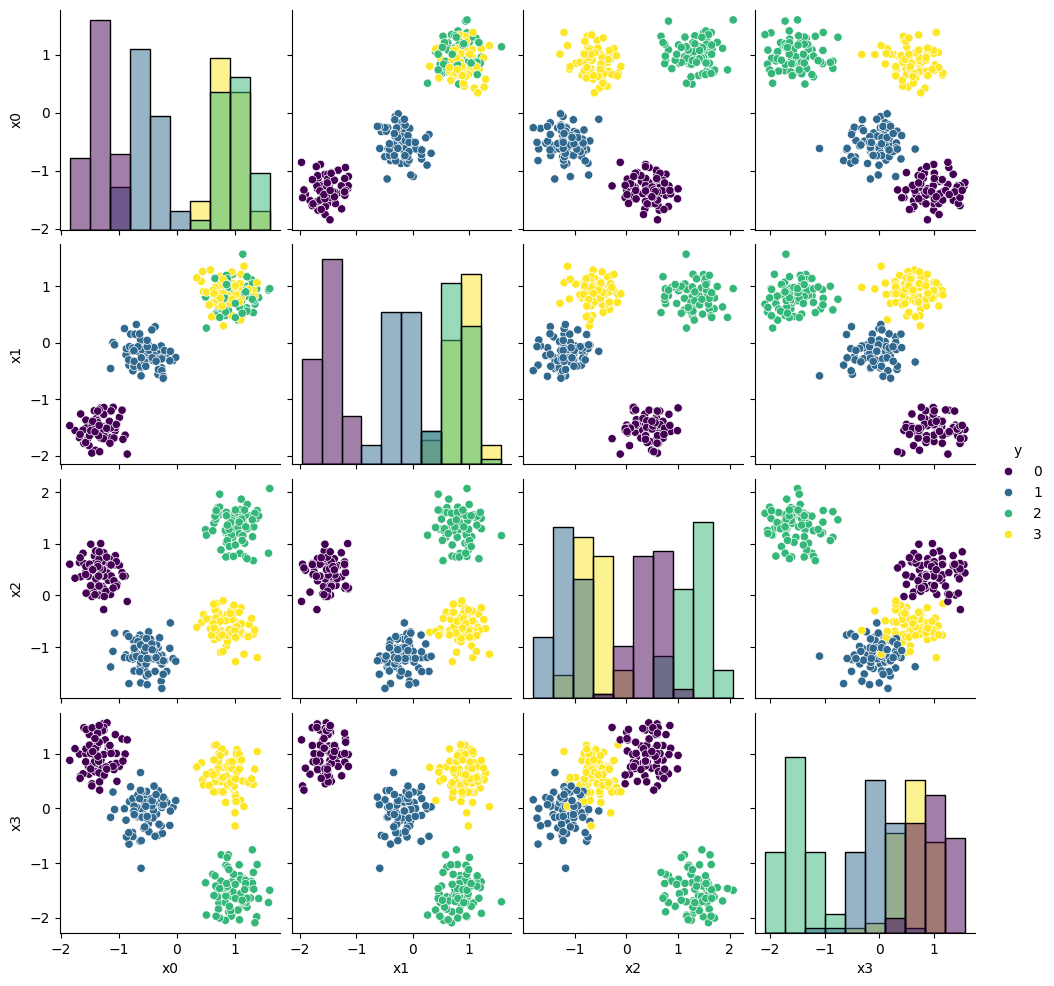

In [27]:
df = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
df['y'] = y
sns.pairplot(df, hue='y', diag_kind='hist', palette='viridis')
plt.plot()

### SKlearn

Inertia: 78.92543985977326
Silhouette Score: 0.7073848342388132
Adjusted Rand Index: 1.0


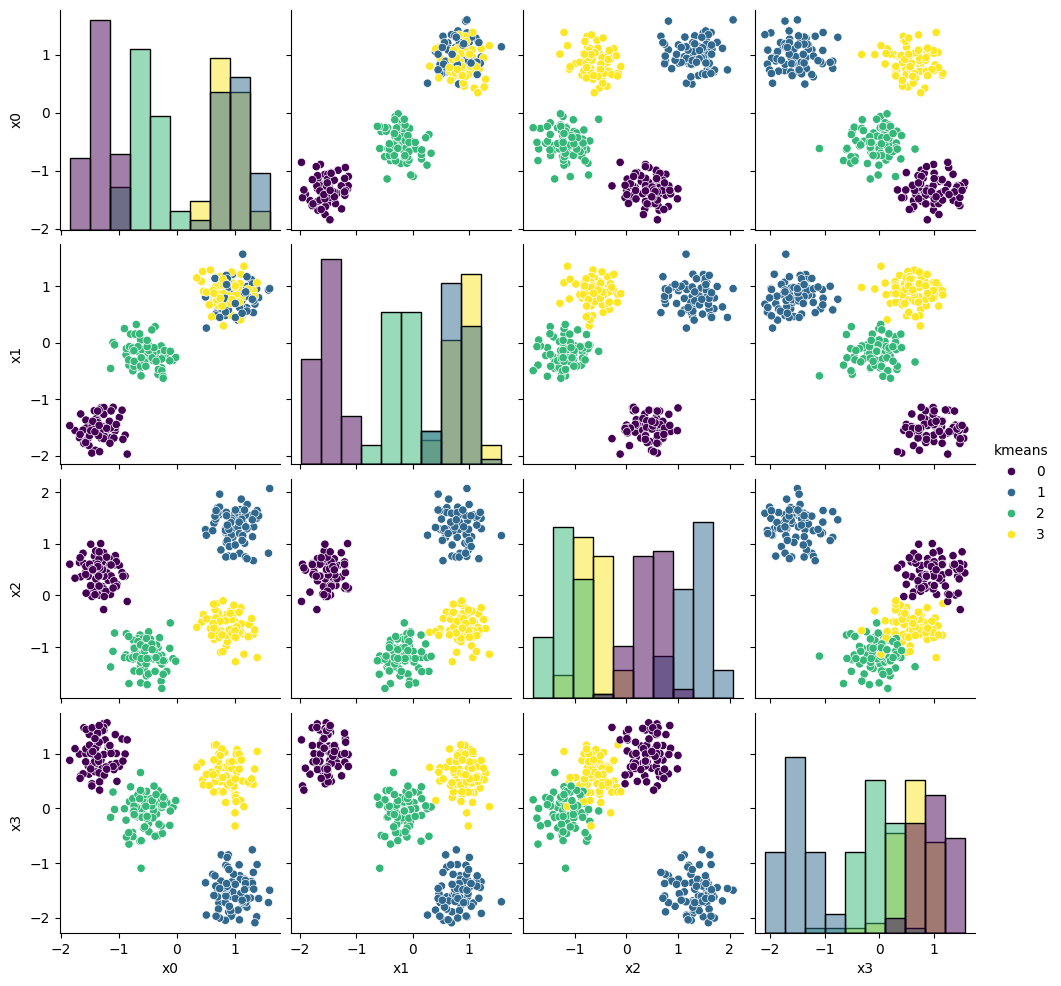

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


print(f'Inertia: {kmeans.inertia_}')

sil_score = silhouette_score(X, y_kmeans)
print(f'Silhouette Score: {sil_score}')

ari_score = adjusted_rand_score(y, y_kmeans)
print(f'Adjusted Rand Index: {ari_score}')

df = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
df['kmeans'] = kmeans.labels_

sns.pairplot(df, hue='kmeans', diag_kind='hist', palette='viridis')
plt.plot();

### Implementation


In [29]:
class KMeansClustering:
    def __init__(self, n_clusters, max_iter=100, show_plot=False):
        assert n_clusters > 0, 'n_clusters should be greater than 0'
        assert max_iter > 0, 'max_iter should be greater than 0'

        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centroids = None
        self.show_plot = show_plot

    def _create_clusters(self, X):
        # X[:, np.newaxis, :] - centroids
        # X = (m, 1, n), centroids = (k, n) -> broadcasting to (m, k, n)
        # where the values are (each sample, difference from centroid, for each feature)
        distances = X[:, np.newaxis, :] - self.centroids
        # distances = (m, k, n) -> (m, k) -> euclidean distance
        # note since euclidean distance is sqrt(sum(x_i - y_i)^2) which is monotonic
        # but expensive, we can replace it with L1 distance sum(|x_i - y_i|)
        # since we are only interested in the closest centroid and not the actual distance
        # this will also avoid overflow errors with squared distances
        distances = np.linalg.norm(distances, ord=1, axis=2)
        # get the index of the closest centroid for each sample
        # (m, k) -> (m,)
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, clusters):
        # sort the clusters and get the indexes
        sort_idx = np.argsort(clusters)
        # split the indexes based on the cluster values
        sorted_clusters = clusters[sort_idx]
        # get the indexes where the clusters change
        splits = np.where(sorted_clusters[:-1] != sorted_clusters[1:])[0] + 1
        # split the indexes based on the cluster changes
        split_indexes = np.split(sort_idx, splits)
        # get the features for each cluster
        return np.array([X[idx].mean(axis=0) for idx in split_indexes])

    def _is_converged(self, prev_centroids, centroids):
        return np.array_equal(prev_centroids, centroids)

    def _get_cluster_labels(self, clusters):
        return clusters

    def fit(self, X):
        X = np.asarray(X)
        assert len(X.shape) == 2, 'X must be 2D array'
        assert self.n_clusters < X.shape[0], 'n_clusters should be less than number of samples'
        assert not np.any(np.isnan(X)) and not np.any(np.isinf(X)), 'X contains NaN or infinite values'

        n_samples, n_features = X.shape

        np.random.seed(42)  # For reproducibility


        # initialize centroids to random samples
        random_sample_idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = np.array([X[idx] for idx in random_sample_idx])

        for iter in range(self.max_iter):
            # create clusters
            clusters = self._create_clusters(X)
            # save current centroids
            prev_centroids = self.centroids.copy()
            # update centroids
            self.centroids = self._update_centroids(X, clusters)

            # plot clusters
            if self.show_plot:
                self.plot_clusters(X, clusters, title=f'Iteration {iter}')

            # check if converged ie centroids not moving
            if self._is_converged(prev_centroids, self.centroids):
                break

        # return cluster labels
        return self._get_cluster_labels(clusters)

    def plot_clusters(self, X, clusters, title):
        df = pd.DataFrame(X, columns=[f'X{i}' for i in range(X.shape[1])])
        df['cluster'] = clusters

        # Adjust the height parameter to make the plot smaller
        g = sns.pairplot(df, hue='cluster', diag_kind='hist', palette='viridis', height=1.5)

        for i in range(len(g.axes)):
            for j in range(len(g.axes)):
                if i != j:
                    ax = g.axes[i][j]
                    ax.scatter(self.centroids[:, j],
                            self.centroids[:, i],
                            c='red',
                            s=100,
                            marker='x')

        plt.suptitle(title)
        plt.show()

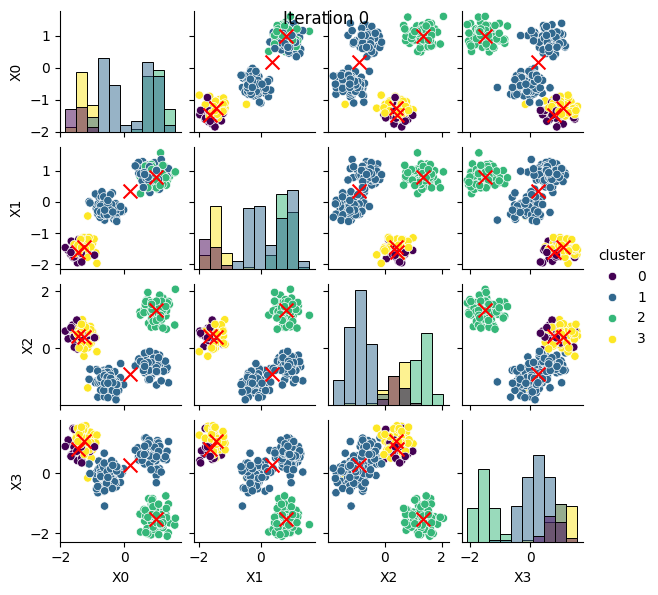

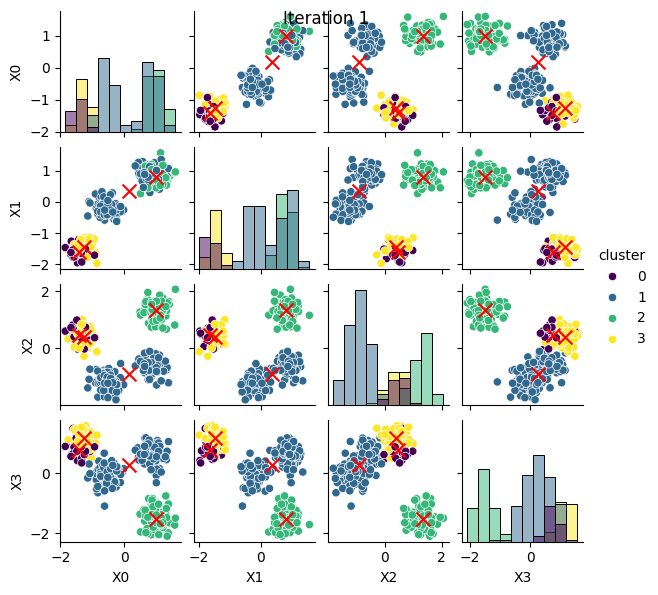

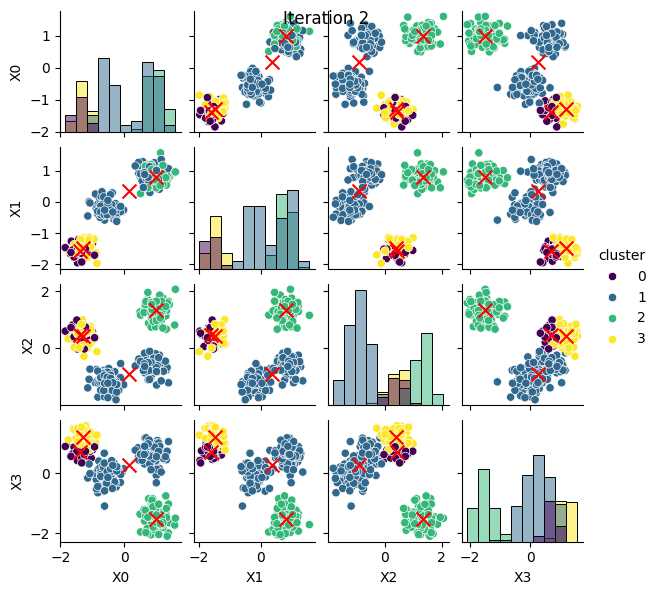

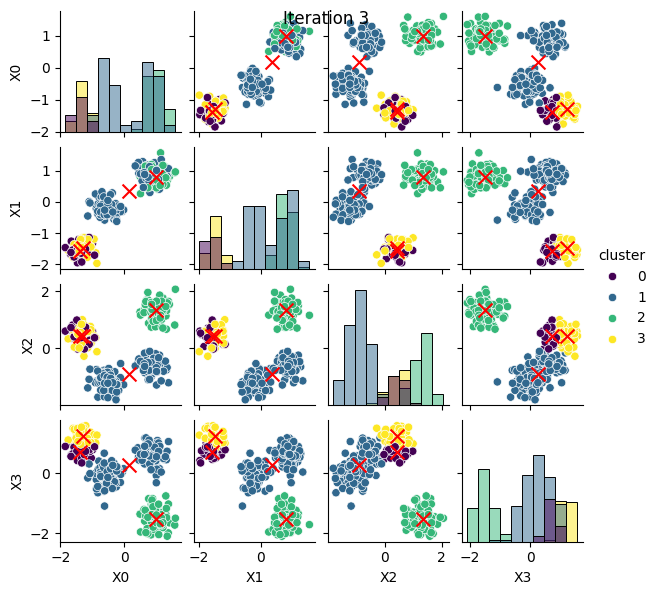

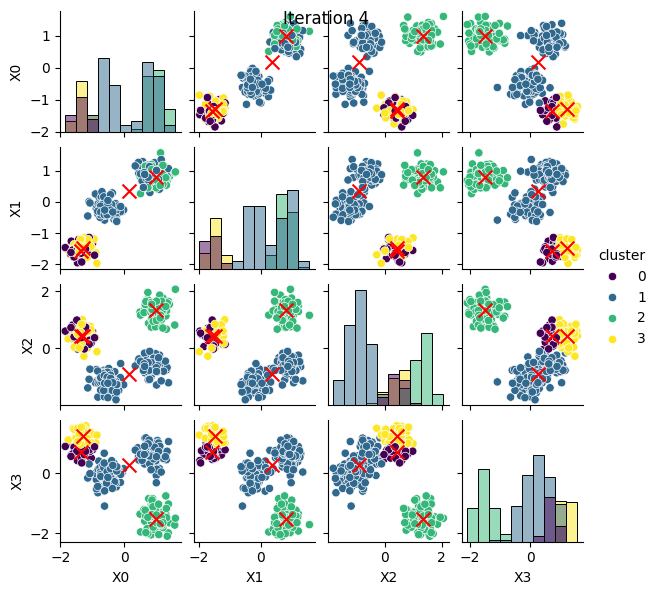

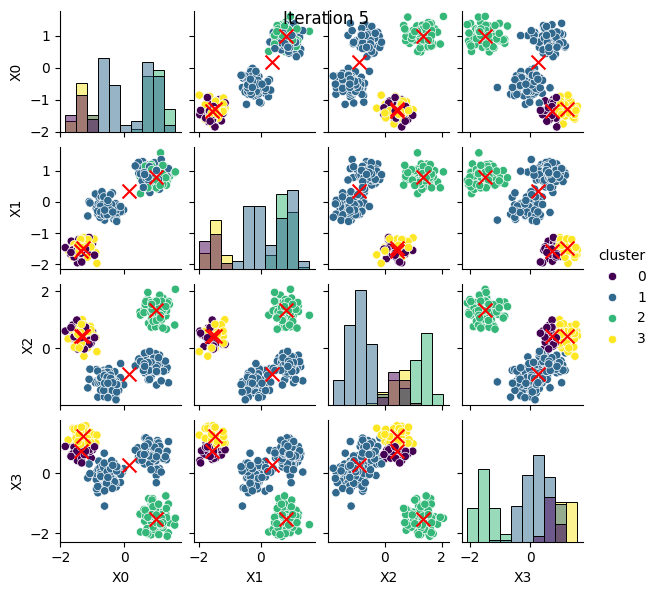

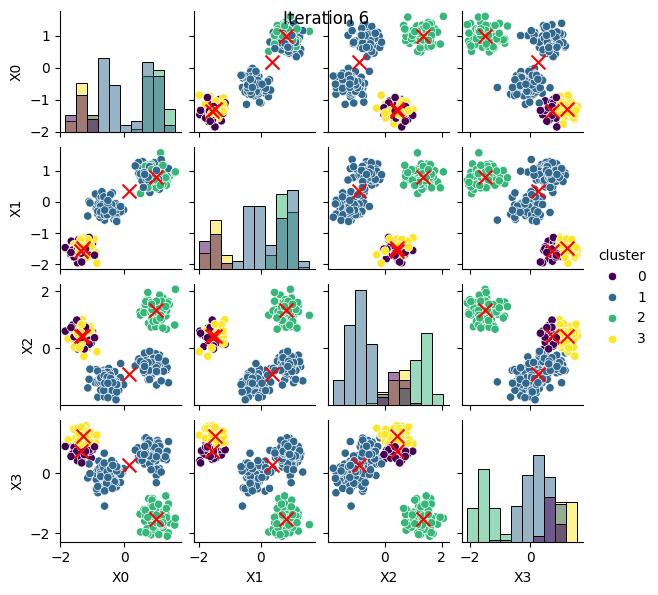

Silhouette Score: 0.49217075932130333
Adjusted Rand Index: 0.6271108961072968


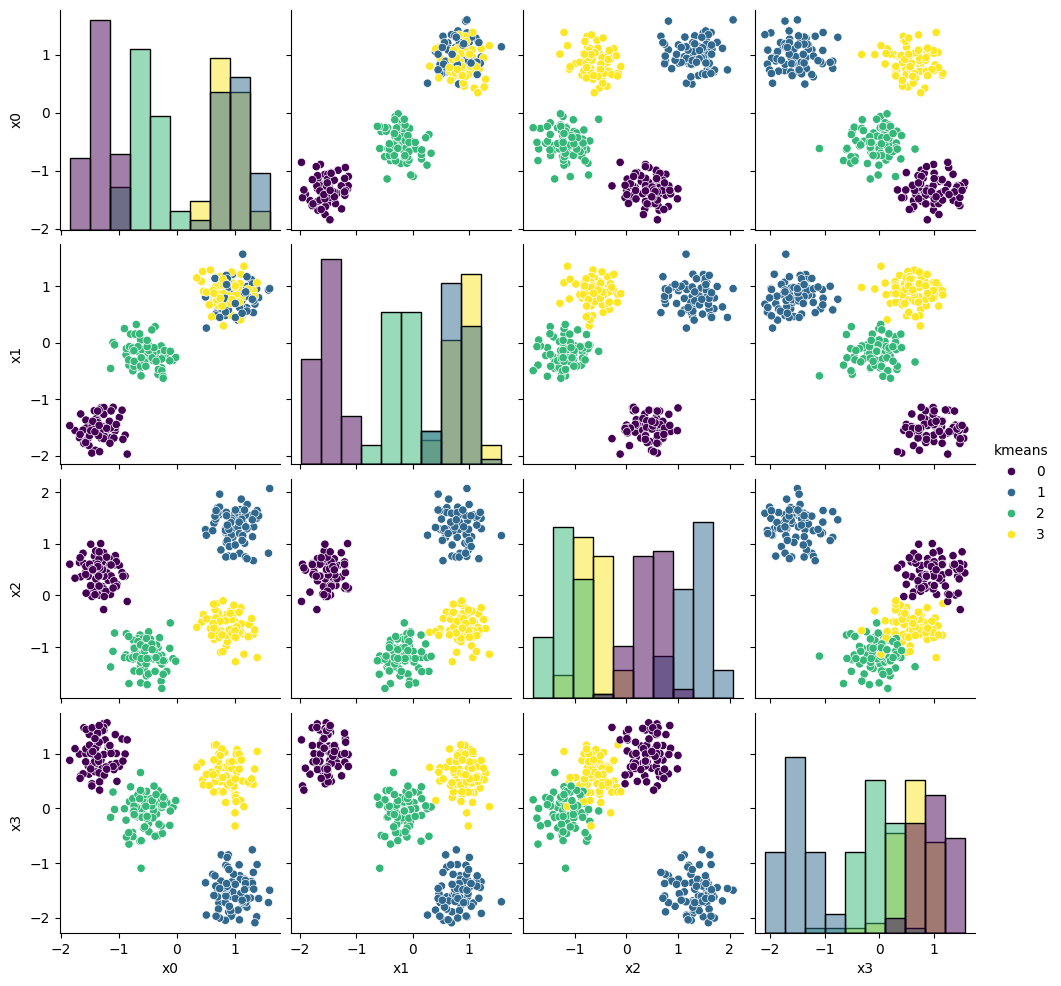

In [30]:
model = KMeansClustering(n_clusters=4, show_plot=True)
y_pred = model.fit(X)

sil_score = silhouette_score(X, y_pred)
print(f'Silhouette Score: {sil_score}')

ari_score = adjusted_rand_score(y, y_pred)
print(f'Adjusted Rand Index: {ari_score}')

df = pd.DataFrame(X, columns=[f'x{i}' for i in range(X.shape[1])])
df['kmeans'] = kmeans.labels_

sns.pairplot(df, hue='kmeans', diag_kind='hist', palette='viridis')
plt.plot();

Note that the clusters plotted in intermediate steps look wrong because they are plotted for those 2 features in comparison only, which might show overlapping result but the actual clustering is done on all the features.

### Conclusion

K-means clustering is a simple and elegant approach for partitioning a data set into K distinct, non-overlapping clusters. To perform K-means clustering, we must first specify the desired number of clusters K; then the K-means algorithm will assign each observation to exactly one of the K clusters.

In this notebook, we implemented the K-means algorithm from scratch and used it to cluster the data points in the 2D plane. We also visualized the clusters and the centroids.